In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
from scipy import fft
from sklearn import linear_model

(256, 256)


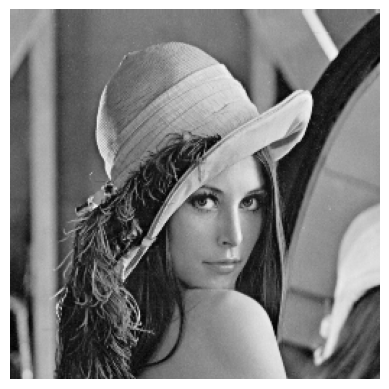

In [2]:
# import the image
img_lena = plt.imread('../Pictures/lena.tif')

print(img_lena.shape)

plt.imshow(img_lena, cmap='gray')
plt.axis('off')
plt.show()

In [3]:
# import the RGB image
img_01 = plt.imread('../Pictures/McM/McM01.tif')

'''
img_01.shape = (512, 512, 3)
where 3 means 3 channels: R, G, B
Extract three channels respectively
'''
img_01_R = img_01[:, :, 0]
img_01_G = img_01[:, :, 1]
img_01_B = img_01[:, :, 2]

# Step 1. Cut the image into patches

In [49]:
class Img2patch:
    def __init__(self):
        pass
    

    def __call__(self, *args, **kwargs):
        if kwargs.get('inv'):
            return self.patch2img(*args)
        else:
            return self.img2patch(*args)
    

    def img2patch(self, img, size, overlapping_rate):
        '''
        Transform the image into patches

        Parameters
        ----------
        img : numpy.ndarray
            The input image
        size : int
            The size of the patch
        repeat_rate : float
            The rate of the overlapping area

        Returns
        -------
        patches : numpy.ndarray
            The patches of the image
        '''
        img_size = img.shape[0] # Number of pixels on each side

        # Cut image into patches
        d_ = int(size**0.5)
        h_ = d_ * (1 - overlapping_rate)
        division_ = np.arange(0, img_size-d_+h_, h_).astype(int)

        patches_ = []
        DC_component_ = []

        for i in range(len(division_)):
            pi_ = division_[i]
            for j in range(len(division_)):
                pj_ = division_[j]
                patch_ = img[pi_:pi_+d_, pj_:pj_+d_]
                patch_ = patch_.reshape(-1, 1)

                DC_component_.append(np.mean(patch_))
                patch_ = patch_ - np.mean(patch_)
                patches_.append(patch_)

        patches_ = np.concatenate(patches_, axis=1)
        return patches_, DC_component_
    
    
    def patch2img(self, patches, overlapping_rate, DC_component):
        '''
        Combining patches into an image

        Parameters
        ----------
        patches : numpy.ndarray
            The patches of the image
        repeat_rate : float
            The rate of the overlapping area
        DC_component : numpy.ndarray
            The DC component of each patch

        Returns
        -------
        img_ : numpy.ndarray
            The image
        '''
        P, N = patches.shape
        d_ = int(P**0.5)
        n_ = int(N**0.5)
        
        img_size_ = int(d_ * (n_ - (n_ - 1) * overlapping_rate)) # Number of pixels on each side
        img_ = np.zeros((img_size_, img_size_)) # Initialize the image

        # Put the patch back in its place
        for idx in range(N):
            patch_ = patches[:, idx].reshape(d_, d_)
            i_ = int((idx // n_) * d_ * (1 - overlapping_rate))
            j_ = int((idx % n_) * d_ * (1 - overlapping_rate))
            
            # Add the DC component
            patch_ = patch_ + DC_component[idx]
            img_[i_:i_+d_, j_:j_+d_] = img_[i_:i_+d_, j_:j_+d_] + patch_

        # Average the overlapping area
        for j in range(1, n_):
            p_ = int(j * d_ * (1 - overlapping_rate))
            img_[:, p_:p_+int(d_ * overlapping_rate)] = img_[:, p_:p_+int(d_ * overlapping_rate)] / 2

        for i in range(1, n_):
            p_ = int(i * d_ * (1 - overlapping_rate))
            img_[p_:p_+int(d_ * overlapping_rate), :] = img_[p_:p_+int(d_ * overlapping_rate), :] / 2

        # Show the image
        plt.imshow(img_, cmap='gray')
        plt.axis('off')
        plt.show()
        return img_


Img2patch = Img2patch()

(256, 441)


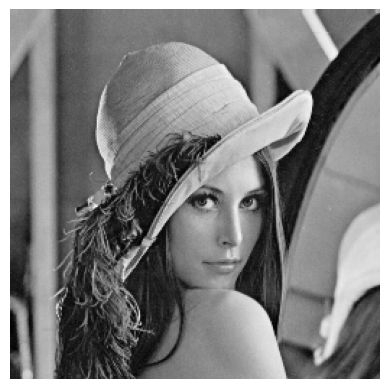

In [5]:
P = 2**8
overlapping_rate = 0.25

patches, DC_component = Img2patch(img_lena, P, overlapping_rate)
print(patches.shape)

Img2patch(patches, 0.25, DC_component, inv=True)

# Step 2: Create the initial dictionary

initial dictionary: DCT over-complete dictionary

In [18]:
mD = fft.dct(np.eye(P*2), norm='ortho')[:P]

## Step 3: K-SVD

### OMP 稀疏编码

OMP（Orthogonal Matching Pursuit）是一种用于稀疏编码的算法，用于找到一组基向量的线性组合，最能够拟合给定观测信号的稀疏表示。其步骤如下：

- **初始化**：设输入信号为y，字典为D（包含一组基向量），稀疏表示向量为x（初始化为零向量）。
- **迭代**：
   1. 计算残差：$ r = y - Dx $。
   2. 选择最相关的原子：找到字典D中与残差r最相关（内积最大）的基向量，假设是第k个基向量。
   3. 更新稀疏表示：$x_k$（第k个系数）更新为$x_k = x_k + \langle d_k, r \rangle$，其中$d_k$是字典中的第k个基向量。
   4. 更新残差：$r = r - \langle d_k, r \rangle \cdot d_k$。
   5. 终止条件：检查稀疏表示向量x是否满足所需的稀疏度或残差大小要求，如果不满足，则继续迭代。

这个算法通过选择与当前残差最相关的基向量来逐步构建稀疏表示，直到达到所需的稀疏度或满足残差收敛要求。OMP是一种简单但有效的稀疏编码方法，在信号处理和压缩感知等领域得到广泛应用。

In [45]:
def OMP(dictionary, sample, sparsity, eps=1):
    '''
    Orthogonal Matching Pursuit

    Parameters
    ----------
    dictionary : numpy.ndarray
        The dictionary
    sample : numpy.ndarray
        The sample
    sparsity : int
        The sparsity
    eps : float
        The threshold

    Returns
    -------
    x : numpy.ndarray
        The sparse representation
    '''
    # Initialization
    mD_ = dictionary.copy()
    mX_ = np.zeros((mD_.shape[1], sample.shape[1]))

    for i in range(sample.shape[1]):
        b = sample[:, i].copy()  # The sample
        x = mX_[:, i]            # The sparse representation

        # Initialize the residual
        r = b.copy()
        k = 0
        
        while k <= sparsity:
            j = np.argmax(np.abs(mD_.T @ r))
            x[j] += mD_[:, j].T @ r
            r = r - mD_[:, j] * (mD_[:, j].T @ r)

            if la.norm(r) < eps:    # If the residual is small enough
                break

            k += 1
        
        mX_[:, i] = x    # Update the sparse representation
    
    return mX_

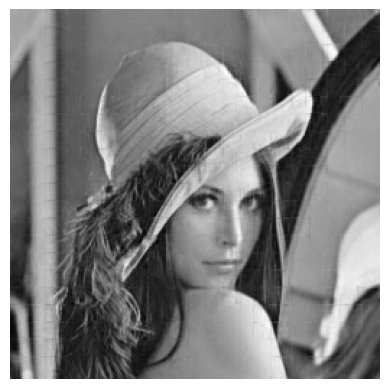

In [50]:
mX = OMP(mD, patches, 64, eps=1)
patches_new = mD @ mX
img_new = Img2patch(patches_new, overlapping_rate, DC_component, inv=True)

### K-SVD

K-SVD算法是一种用于字典学习的迭代优化算法，其步骤如下：

1. **初始化字典**：开始时需要一个初始的字典。可以是随机选择的字典或通过其他方式预先构建的字典。

2. **稀疏编码**：对于给定的样本集合，使用当前的字典对样本进行稀疏编码。这意味着用字典中的原子线性组合来表示每个样本，通常使用一些稀疏编码方法，比如OMP（Orthogonal Matching Pursuit）或基于凸优化的方法。

3. **更新字典**：在这一步中，逐个更新字典中的原子（基向量）。对于每个原子，以下步骤在所有样本上进行：
   - **选取样本**：选取使用当前原子表示的样本。
   - **更新原子**：对选定的样本进行残差计算，并使用某种优化方法（如最小化残差的方式）来更新字典中的原子。

4. **重复迭代**：重复步骤2和步骤3，直到满足停止条件，比如达到最大迭代次数、字典不再发生显著变化、或者达到一定的收敛条件。

在K-SVD算法中，关键的步骤是稀疏编码和字典更新。稀疏编码确定了如何用当前的字典表示样本，而字典更新阶段则利用这些表示来更新字典，使其能够更好地拟合样本数据，提高稀疏表示的质量。

K-SVD算法通常应用于信号处理、图像处理等领域，用于从数据中学习最能代表数据特征的基本元素。

In [53]:
def Phi(D, A, X=patches):
    E = X - D @ A
    return la.norm(E, ord='fro')**2 / 2


def grad_Phi(D, A, X=patches):
    return -(X - D @ A) @ A.T

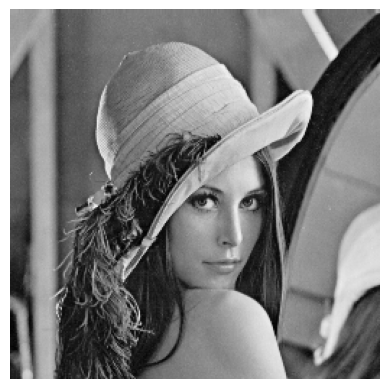

In [67]:
mD_new = la.lstsq(mX.T, patches.T)[0].T
# mX_new = OMP(mD_new, patches, 128, eps=1)
patches_new = mD_new @ mX
img_new = Img2patch(patches_new, overlapping_rate, DC_component, inv=True)